In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Simulating SNP Data Set

Do to the fact that we were unable to acquire real individual-level SNP data with an associated heart disease label, we have decided to simulate our own data set. In order to do this, we will be utilizing a separate GWAS to determine relevent SNPs to coronary heart disease and disperse them across a 'population' based on their minor allele frequencies.

**1. Let's begin by loading in a GWAS data set which was acquired from the GWAS Catalog (https://www.ebi.ac.uk/gwas/efotraits/EFO_0001645).**

In [2]:
coronary_heart = pd.read_csv('../testdata/gwas/gwas_simulate.csv')

# Cleaning to include only SNPs with beta values
coronary_heart = coronary_heart.dropna(subset=['beta', 'effect_allele_frequency'], axis=0)
coronary_heart = coronary_heart.drop_duplicates()

**2. Now we will be mapping these SNPs to a synthetic population based on their associated Risk Allele Frequencies. The population we are creating will consist of 10,000 'people'.**

In [3]:
indiv_rows = []

N = 10000
for _ in range(N):
    has_snps = (coronary_heart['effect_allele_frequency']
                .apply(lambda x: np.random.choice(a=[0,1], p=[1-x, x])))
    indiv_rows.append(has_snps.values)
    
simulated_df = pd.DataFrame(indiv_rows, columns=coronary_heart['variant_id'])
simulated_df.columns.name = ''
simulated_df.head()

,rs138741635,rs147204125,rs149232047,rs16999497,rs151269874,rs192427471,rs12290663,rs11915606,rs148121703,rs201394051,...,rs4468572,rs28451064,rs56289821,rs1870634,rs9970807,rs67180937,rs1412444,rs2519093,rs12202017,rs2487928
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,0,1,1


**3. Finally, we can calculate the polygenic risk score for each individual.**

This score will be calculated using the following formula:

<center>$PRS_i = \sum_j^{N}\beta_j*SNP_{ij}$</center>

Where $\beta_j$ is the beta score (weight) for the $j^{th}$ SNP, $SNP_{ij}$ is a binary value representing whether the $i^{th}$ individual has the $j^{th}$ SNP. The formula is followed from https://sahirbhatnagar.com/blog/2017/08/11/polygenic-risks-scores-with-data.table-in-r/.

These beta values are provided to us through the GWAS file loaded above. Let's sort them in the right order so that we can efficiently generate polygenic risk scores using some matrix algebra:

In [4]:
beta_dict = coronary_heart.set_index('variant_id')['beta'].to_dict()
beta_values = np.array([beta_dict.get(x) for x in simulated_df.columns])

Now we do the polygenic risk score calculation

In [5]:
prs = simulated_df.apply(lambda x: (x*beta_values).sum(), axis=1)
simulated_df['PRS'] = prs
simulated_df.head()

,rs138741635,rs147204125,rs149232047,rs16999497,rs151269874,rs192427471,rs12290663,rs11915606,rs148121703,rs201394051,...,rs28451064,rs56289821,rs1870634,rs9970807,rs67180937,rs1412444,rs2519093,rs12202017,rs2487928,PRS
0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,0,198.099672
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,1,1,219.871640
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,0,0,1,0,175.396540
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,211.470342
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,1,210.751069


Let's evaluate the distribution.

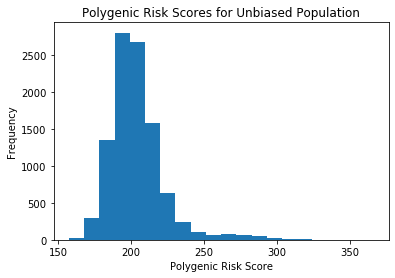

In [6]:
plt.hist(simulated_df['PRS'], bins=20)
plt.title('Polygenic Risk Scores for Unbiased Population')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency');

**4. Additional Step: Here we will generate a biased data set. We will intentionally give different individuals higher probabilities of having particular SNPs. This will allow us to create low, average, and high risk individuals.**

We begin by modifying step 3 to include such a bias:

In [7]:
# Creating labels that will be associated with disease risk
# 0=Low   1=Mid   2=High
risk_labels = [0, 1, 2]

# Define the probability of being a label
# Low=55%   Mid=30%   High=15%
risk_prob = [.6, .3, .1]

# Defining values to scale probability of having SNP
low_risk_bias = np.arange(.1, .5, .05)
medium_risk_bias = np.arange(.5, .76, .05)
high_risk_bias = np.arange(.75, 1, .05)
risk_bias = [low_risk_bias, medium_risk_bias, high_risk_bias]

# Simulating
indiv_rows_bias = []
indiv_class = []
N = 10000
for _ in range(N):
    label = np.random.choice(a=risk_labels, p=risk_prob)
    bias = np.random.choice(risk_bias[label])
    has_snps = (coronary_heart['effect_allele_frequency']
                .apply(lambda x: 
                        np.random.choice(a=[0,1], p=[1-(x*bias), (x*bias)])))
    indiv_rows_bias.append(has_snps.values)
    indiv_class.append(label)
    
    
simulated_bias_df = pd.DataFrame(indiv_rows_bias, columns=coronary_heart['variant_id'])
simulated_bias_df.columns.name = ''
simulated_bias_df.head()

,rs138741635,rs147204125,rs149232047,rs16999497,rs151269874,rs192427471,rs12290663,rs11915606,rs148121703,rs201394051,...,rs4468572,rs28451064,rs56289821,rs1870634,rs9970807,rs67180937,rs1412444,rs2519093,rs12202017,rs2487928
0,0,0,0,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


We again calculate the polygenic risk scores.

In [8]:
prs2 = simulated_bias_df.apply(lambda x: (x*beta_values).sum(), axis=1)
simulated_bias_df['PRS'] = prs2
simulated_bias_df.head()

,rs138741635,rs147204125,rs149232047,rs16999497,rs151269874,rs192427471,rs12290663,rs11915606,rs148121703,rs201394051,...,rs28451064,rs56289821,rs1870634,rs9970807,rs67180937,rs1412444,rs2519093,rs12202017,rs2487928,PRS
0,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,98.288942
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,80.370200
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,1,107.199390
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,55.079992
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,24.535400


Let's evaluate the distribution.

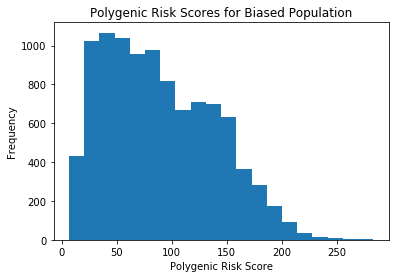

In [9]:
plt.hist(simulated_bias_df['PRS'], bins=20)
plt.title('Polygenic Risk Scores for Biased Population')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency');

Let's evaluate the assignment of labels.

In [10]:
pd.Series(indiv_class).value_counts(normalize=True)

0    0.5972
1    0.3030
2    0.0998
dtype: float64

Finally, let's see if our biased term worked.

In [11]:
# Adding label to data set
simulated_bias_df['Label'] = indiv_class

# Determining mean polygenic score per label
simulated_bias_df.groupby('Label')['PRS'].mean()

Label
0     55.649382
1    127.688460
2    173.875941
Name: PRS, dtype: float64

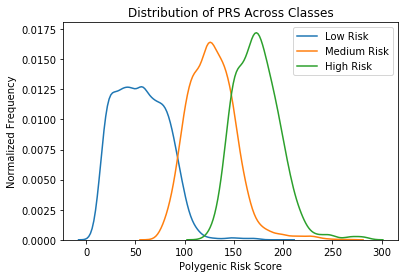

In [12]:
sns.kdeplot(simulated_bias_df[simulated_bias_df['Label'] == 0]['PRS'], label="Low Risk")
sns.kdeplot(simulated_bias_df[simulated_bias_df['Label'] == 1]['PRS'], label="Medium Risk")
sns.kdeplot(simulated_bias_df[simulated_bias_df['Label'] == 2]['PRS'], label="High Risk")
plt.title('Distribution of PRS Across Classes')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Normalized Frequency');

As can be seen, our bias worked and those with mid and high risks of the disease had higher polygenic risk scores. We hope that we are able to build a model on this labeled data.